## Video Object Recognition

For this project, I will be using [OpenCV](https://opencv.org/) an Open Source computer vision library for my video and image processing.   
I'll be using a trained TensorFlow model from [TensorFlow Zoo](https://github.com/tensorflow/models), specifically the [SSD MobileNet V1 Coco](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model.   
The model is contained within the'frozen_inference_graph.pb' from the zip file, and will allow me to identify objects.   
The [labels.txt](https://github.com/nightrome/cocostuff/blob/master/labels.txt) file is also necessary to get the corresponding labels.  
I'll also be using pictures and videos from [pixabay](https://pixabay.com) to test the object recognition model.

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2 as cv

First, I'll load the labels. The file is in the format:   
0: unlabeled   
1: person   
2: bicycle
...   
Thus, I will need to build a lookup to convert the predicted label number returned by the model to a string.

In [21]:
# Read the file in
with open('labels.txt', 'r') as f:
    labels = f.readlines()

# Remove the indexes


# Strip leading and trailing whitespace
labels = list(map(lambda x: x.strip(), labels))

print("There are", len(labels), "labels")
print("The label at 50 is:", labels[0])

There are 50 labels
The label at 50 is: pig


## Load the model 

Loading a model in TensorFlow is done by reading the file in binary format and then parsing it into a `GraphDef` object.

In [23]:
with tf.gfile.FastGFile('./new_graph/frozen_inference_graph.pb','rb') as f:
  graph_def = tf.GraphDef()
  graph_def.ParseFromString(f.read())

Below is a function that takes in an image and TensorFlow session, resizes the image, runs it through the model, and returns the predictions to us (as well as bounding boxes for each of the identified objects). For each identified object, the model also returns a detection score showing how sure the model is of a prediction. Right now, I have the code to accept thresholds, but we'll have it set at 0.2, so if the model is 20% sure or higher about the object identified, I'll draw the bounding boxes and add a label. 

We define the TensorFlow session outside of the function and pass it into the session as intializing the session is resource intensive and not efficient.

The model expects a 300x300 image input, so we'll need to multiply the bounding box coordinates returned by the model by the original width and height to place them on the original frame.

## Function that labels a single image

In [24]:
def labelImage(image, sess):

    # The model expects a 300x300 image as input
    image_scaled = cv.resize(image, (300, 300))

    detections = sess.run([
        sess.graph.get_tensor_by_name('num_detections:0'),    # [0] in detections
        sess.graph.get_tensor_by_name('detection_scores:0'),  # [1] in detections
        sess.graph.get_tensor_by_name('detection_boxes:0'),   # [2] in detections
        sess.graph.get_tensor_by_name('detection_classes:0'), # [3] in detections
    ], feed_dict={
        'image_tensor:0': image_scaled.reshape(
            1, image_scaled.shape[0], image_scaled.shape[1], 3)
    })


    # num_detections:0
    detection_count = int(detections[0][0])

    # because we scale the image, we should get the original height & width so we can scale back
    height = image.shape[0]
    width = image.shape[1]
    r_img = 255
    g_img = 0
    b_img = 0

    r_text = 0
    g_text = 0
    b_text = 0
    scale = 0.6
    thickness = 2
    
    threshold = 0.2

    for i in range(detection_count):
      # detection_scores:0
      confidence_score = detections[1][0][i]
      
      if confidence_score > threshold:

        # detection_boxes:0
        box = detections[2][0][i]
    
        # we multiply by height and width because the coordinates returned by the model are
        # from the scaled image
        top_img = int(box[0]*height)
        left_img = int(box[1]*width)
        bottom_img = int(box[2]*height)
        right_img = int(box[3]*width)
        
        # adding the bounding box rectangle
        cv.rectangle(image, (left_img, top_img), (right_img, bottom_img), (r_img, g_img, b_img), thickness=2)
        # adding a filled rectangle above the bounding box so the text can be seen
        cv.rectangle(image, (left_img, top_img), (right_img, top_img-20), (r_img, g_img, b_img), thickness=cv.FILLED)

        # detection_classes:0
        label_id = int(detections[3][0][i])
        label_name = labels[label_id]
        
        # adding the label
        cv.putText(image, label_name, (left_img, top_img-3), cv.FONT_HERSHEY_SIMPLEX, scale, [r_text, g_text, b_text], thickness)
      else:
        break
    return image

Let's pass in an image to ensure that the function works.

<IPython.core.display.Javascript object>


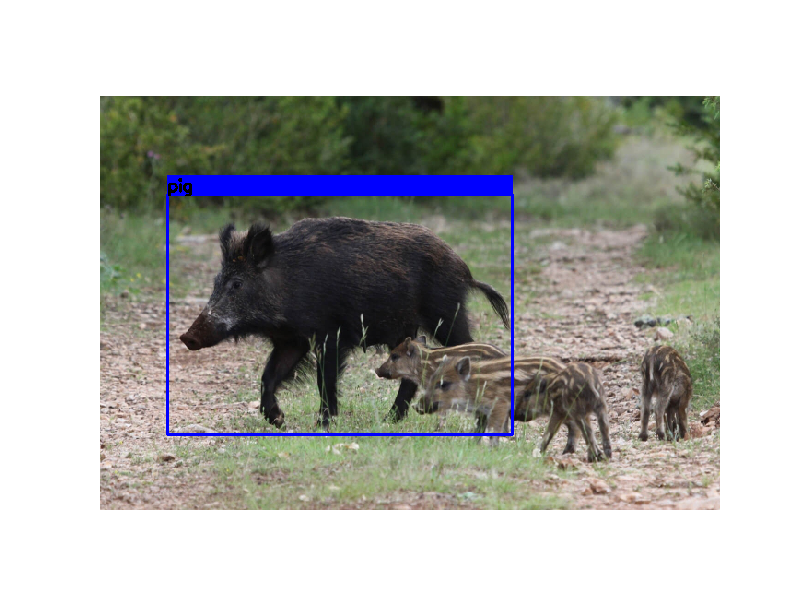

In [25]:
import cv2 as cv
import matplotlib.pyplot as plt

%matplotlib notebook
with tf.Session() as sess:
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')
    
    image = cv.imread('image2.jpg')
    new_image = labelImage(image, sess)
    new_image = cv.cvtColor(new_image, cv.COLOR_BGR2RGB)
    plt.imshow(new_image)
    plt.grid(False)
    plt.axis('off')
    plt.show()

Now that we know our function works, we can create another function to pass in a video!   
We will use OpenCV to read in a video as individual frames. We'll then send each of those frames to our `labelImage()` function and have the returned images written as a .mp4 output.
For large videos, we should not send every frame to be processed - this will take a long time. However, by skipping frames, it'll make the video appear sped up. This can be adjusted by the `frames` parameter, which will control how many frames are skipped. If we don't want any frames skipped, this can be set at 1.   
Note that we are defining one TensorFlow session and putting all our calls to the model (which is called inside the `labelImage()` function) inside that session.

## Processing the video 

In [26]:
def processVideo(filename, output, frames):
    cap = cv.VideoCapture(filename)

    height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
    width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
    fps = cap.get(cv.CAP_PROP_FPS)
    total_frames = int(cap.get(cv.CAP_PROP_FRAME_COUNT))

    fourcc = cv.VideoWriter_fourcc(*'MP4V')
    output = cv.VideoWriter(output, fourcc, fps, (width, height))

    with tf.Session() as sess:
        sess.graph.as_default()
        tf.import_graph_def(graph_def, name='')

        for i in range(0, total_frames, frames):
          cap.set(cv.CAP_PROP_POS_FRAMES, i)
          ret, frame = cap.read()
          if not ret:
            raise Exception("Problem reading frame", i, " from video")
          else:
            result = labelImage(frame, sess)
            output.write(result)

    cap.release()
    output.release()

Let's pass in a [video](https://pixabay.com/videos/motorcycle-city-motorbike-street-6098/) of a street involving pedestrians, motorcycles, and cars.

In [33]:
processVideo('SLO.mp4','SLO8-labeled.mp4', 1)

Exception: ('Problem reading frame', 416, ' from video')

The video will be saved to my directory, but I've uploaded it to Vimeo as using HTML to display videos had issues on Chrome:

In [ ]:
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/323023943',width="560", height="315")

As you can see, this model is not perfect, but runs fast and allows for a great introductory to object recognition.   
Here are some additional examples below:

In [32]:
processVideo('seoul.mp4', 'seoul-labeled.mp4', 1)
# https://pixabay.com/videos/seoul-street-traffic-cars-speed-21115/

In [10]:
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/323023962',width="560", height="315")

In [11]:
processVideo('pedestrians.mp4', 'pedestrians-labeled.mp4', 1)
# https://pixabay.com/videos/pedestrians-road-city-cars-traffic-1023/

In [12]:
from IPython.display import IFrame
IFrame('https://player.vimeo.com/video/323023956',width="560", height="315")